# Noise Parameter Scaling/Tuning

I was having some trouble making the canonical noise scaling work, so I came up with an alternative method. This method takes advantage of the fact that since all of the $\lambda_k(P_k\rho P_k-\rho)$ channels in the Lindbladian commute, a channel can be constructed to scale the parameters $\lambda_k$ individually. 

The first part of the notebook shows how the parameters can be scaled uniformly to achieve an effect similar to canonical noise scaling. I called this method parameter scaling. The second part of the notebook shows how individual interaction parameters can be tuned to great/smaller than hardware noise, what I called noise tuning.

In [1]:
#helper libraries
import numpy as np
from numpy.random import rand
import math
import scipy.optimize
import matplotlib.pyplot as plt

#qiskit functionalities
from qiskit import Aer, execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_histogram

#noise model stuff
from qiskit.providers.aer.noise import NoiseModel, kraus_error, pauli_error
    
#operator info
from qiskit.quantum_info import Pauli, Kraus

from mitiq.zne.inference import mitiq_curve_fit, mitiq_polyfit

Parameters for the model

In [2]:
T = [Pauli("X"), Pauli("Y"), Pauli("Z")] #These are the terms considered in the model
coeffs = [.05, .05, .05] #These are the corresponding lambdas
omegas = np.multiply(.5, np.add(1, np.exp(np.multiply(-2.0, coeffs)))) #Equation (S9)
overhead = np.exp(2.0*np.sum(coeffs)) #below Eq (5)

Build the corresponding noise model for use in the simulations

In [3]:
kraus_ops = Kraus(np.identity(2)) #Start with identity map

#Repeatedly compose (w_kI+(1-w_k)P_k) to get error channel as Kraus map
for i in range(len(T)):
    op = Kraus([T[i].to_matrix()*np.sqrt(1-omegas[i]),np.sqrt(omegas[i])*np.identity(2)]);
    kraus_ops = kraus_ops.compose(op);

kraus_error_channel = kraus_error(kraus_ops.data) #create kraus error channel from kraus map
kraus_noise_model = NoiseModel() #create noise model from kraus error channel
kraus_noise_model.add_all_qubit_quantum_error(kraus_error_channel, ['id', 'rx', 'ry', 'rz']) #add noise to all gates
kraus_basis_gates = kraus_noise_model.basis_gates #get noisy basis gates

/home/ben/anaconda3/envs/mitiq/lib/python3.8/site-packages/qiskit/quantum_info/operators/channel/kraus.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if isinstance(data, np.ndarray) or np.array(data).ndim == 2:


## Parameter Noise Scaling

I observed that the Sparse Pauli-Lindblad model gives rise to an intuitive definition of scaled noise by taking $\lambda_k \to \lambda \lambda_k$, where $\lambda \in [0,1]$ is the strength of the noise. Since all the terms in $\mathcal{L}$ are mutually commuting,

$$
e^{\lambda \mathcal{L}(\rho)} = e^{\mathcal{L}(\rho)-\mathcal{L}(\rho)}e^{\lambda \mathcal{L}(\rho)} = \Lambda(\rho) e^{-(1-\lambda)\mathcal{L}(\rho)}
$$

Let 
$$
\Lambda_{(\lambda)}(\rho) \equiv e^{-(1-\lambda)\mathcal{L}(\rho)}
$$

be the map that takes the noise to the desired strength. This map can be expanded into product form as before:

$$
\Lambda_{(\lambda)}(\rho) = \prod_k\frac{1}{2}(e^{2(1-\lambda)\lambda_k}+1)\rho-\frac{1}{2}(e^{2(1-\lambda)\lambda_k}-1)P_k\rho P_k
$$

When $\lambda < 1$, it can be seen that $e^{2(1-\lambda)\lambda_k} > 1$, so the second term is negative. The overhead of the $k^\text{th}$ term is then
$$
\gamma_{(\lambda)}^{(k)} = \frac{1}{2}(e^{2(1-\lambda)\lambda_k}+1)+\frac{1}{2}(e^{2(1-\lambda)\lambda_k}-1) = e^{2(1-\lambda)\lambda_k}
$$
And the total overhead is
$$
\gamma_{(\lambda)} = \prod_{k \in \mathcal{T}} \gamma_{(\lambda)}^{(k)} = e^{2(1-\lambda)\sum_k\lambda_k} = \gamma^{1-\lambda}
$$
The term $\phi_k \equiv \frac{1}{2}(1+e^{-2(1-\lambda)\lambda_k})$ can be used to write the product in quasiprobability form:
$$
\Lambda_{(\lambda)}(\rho) = \gamma_{(\lambda)}\prod_{k\in\mathcal{T}} \phi_k \rho-(1-\phi_k)P_k\rho P_k
$$
The sampling can be accomplished with the same procedure as the inverse map. In the case where $\lambda > 1$, then the second term in the sum is positive, and the product is already a probability distribution with overhead $1$.

There is no natural limit to the scaling of this noise above hardware level. The largest error probability is
$$
\prod_k \frac{1}{2}(1-e^{-2(\lambda-1)\lambda_k}) < \left(\frac{1-e^{-2(\lambda-1)\lambda_{min}}}{2}\right)^k <1
$$
Since $e^{-2(\lambda-1)\lambda_{min}}\leq 1$ for all $\lambda_{min}$, there is no upper bound on $\lambda$.

In [27]:
samples = 1000
shots = 100
#Follow the procedure for sampling gates
def uniform_noise_scaling(lmbda, samples, gate_to_mitigate):
    
    total = 0 #store the estimator
    phis = .5*(np.exp(np.multiply(-2.0*np.abs(1-lmbda), coeffs))+1) #new adjusted coefficients
    
    if(lmbda < 1):
        gamma = overhead**(1-lmbda) #new overhead
    else:
        gamma = 1
    
    backend = Aer.get_backend('qasm_simulator') #getting closer to this being a real QPU
    
    for i in range(samples):
        m = 1 #store the sign
        op = gate_to_mitigate #start with the target gate
        for (phi, Pk) in zip(phis, T):
            if rand() < 1-phi: #sample the pauli with prob 1-phi
                m*=-1
                op = op.compose(Pk)
                
        qc = QuantumCircuit(1,1) 
        qc.append(op.to_instruction(),[0]) #apply combination of paulis in circuit
        qc.measure(0,0)
        
        if(lmbda > 1): #no sign adjustments if noise is being scaled up
            m = 1
        
        #run one shot of this circuit
        counts = execute(qc, backend, noise_model=kraus_noise_model, 
                        basis_gates = kraus_basis_gates, shots = shots,
                        optimization_level = 0).result().get_counts()
        
        total += (counts.get('0',0)-counts.get('1',0))*m/shots #update estimator
    
    mitigated_value = total/samples*gamma #scale by overhead for final value
    
    return mitigated_value

## Uniform scaling test

Testing the uniform scaling method for different strengths of noise

In [28]:
lmbdas = [0, .33, .66, 1, 1.33]
mitigated_values_scaling = []
samples = 4096
#Run the procedure for each lambda
for lmbda in lmbdas:
    mitigated_value = uniform_noise_scaling(lmbda, samples, Pauli('X'))
    mitigated_values_scaling.append(mitigated_value)
    
#get unmitigated value
qc = QuantumCircuit(1,1)
qc.x(0)
qc.measure(0,0)
backend = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend, noise_model=kraus_noise_model, 
                        basis_gates = kraus_basis_gates, shots = samples,
                        optimization_level = 0).result().get_counts()

unmitigated_value = (counts.get('0',0)-counts.get('1',0))/samples

In [32]:
from scipy.optimize import curve_fit

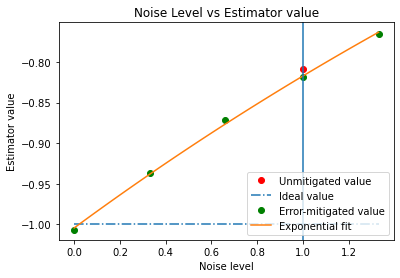

In [37]:


xrange = np.linspace(0, max(lmbdas), 100)
mvs, = plt.plot(lmbdas, mitigated_values_scaling, 'go')
iv, = plt.plot(xrange, [-1]*len(xrange), '-.')
umv, = plt.plot(1, unmitigated_value, 'ro')
expfit = lambda x,a,b : -a*np.exp(-b*x)
popt,pcov = curve_fit(expfit, lmbdas, mitigated_values_scaling)
fit, = plt.plot(xrange, [expfit(x, *popt) for x in xrange])
plt.xlabel("Noise level")
plt.ylabel("Estimator value")
plt.axvline(1)
plt.title("Noise Level vs Estimator value")
plt.legend([umv, iv, mvs, fit], ['Unmitigated value','Ideal value','Error-mitigated value','Exponential fit'], loc="lower right")

## Virtual ZNE
Using the parameter scaling method to carry out virtual zero noise extrapolation using the mitiq package


In [7]:
scale_factors = [.2, .4, .8, 1.2] #Scale factors used for the fit
shot_list  = [1000]*len(scale_factors) #Shots on each fit, ideally used for weighting results

mitigated_values = [uniform_noise_scaling(lmbda, numshots, Pauli('X')) for (lmbda, numshots) in zip(scale_factors, shot_list)] #compute noise-scaled expectations

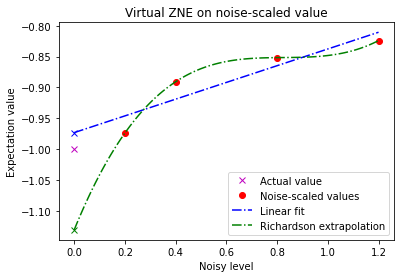

In [8]:
#generalized polynomial function
def polynomial(x, *params):
    return np.sum([x**i*param for (i,param) in enumerate(params)])

#exponential with polynomial parameter, inspired by the polyexp factory
def polyexpo(x, *params):
    return params[0]-np.exp(polynomial(x, *params[1:]))

lin_fit = mitiq_polyfit(scale_factors, mitigated_values, 1) #perform a linear fit
richardson_fit = mitiq_polyfit(scale_factors, mitigated_values, len(scale_factors)-1) #richardson extrapolation
#polyexpo_fit = mitiq_curve_fit(lambda x,a,b : polyexpo(x,a,b), scale_factors, mitigated_values) did not produce usable results

#plot results
xrange = np.linspace(0, np.max(scale_factors), 100)
mv, = plt.plot(scale_factors, mitigated_values, 'ro')
lin, = plt.plot(xrange, [polynomial(x, *lin_fit[0][::-1]) for x in xrange], 'b-.')
plt.plot(0, polynomial(0, *lin_fit[0][::-1]),'bx')
poly, = plt.plot(xrange, [polynomial(x, *richardson_fit[0][::-1]) for x in xrange], 'g-.')
plt.plot(0, polynomial(0, *richardson_fit[0][::-1]),'gx')
av, = plt.plot(0,-1, 'mx')
plt.legend([av, mv, lin, poly],["Actual value","Noise-scaled values", "Linear fit", "Richardson extrapolation"], loc = "lower right")
plt.title("Virtual ZNE on noise-scaled value")
plt.xlabel("Noisy level")
plt.ylabel("Expectation value");



## Tunable Noise

Another observation about this model is that each of the parameters can be tuned using the sampling method. Let
$$
\mathcal{L}_{\vec \lambda}(\rho) \equiv \sum_k \lambda_k(P_k\rho P_k-\rho)
$$
Since all of the terms in $\mathcal{L}_{\vec \lambda}$ and $\mathcal{L}_{\vec \phi}$ commute with each other,
$$
\exp(\mathcal{L}_{\vec \lambda})\exp(\mathcal{L}_{\vec \phi-\vec \lambda}) = \exp(\mathcal{L}_{\vec \lambda})\exp(-\mathcal{L}_{\vec \lambda})\exp(\mathcal{L}_{\vec \phi}) = \exp(\mathcal{L}_{\vec \phi})
$$
The map $\Lambda_{\vec \phi-\vec \lambda} = e^{\mathcal{L}_{\vec \phi-\vec \lambda}}$ can be implemented to produce a noise model with individually tuned parameters. The product form is just as before:
$$
\Lambda_{\vec \phi-\vec \lambda}(\rho) = \prod_k \frac{1}{2}(1+e^{2(\lambda_k-\phi_k)})\rho - \frac{1}{2}(1-e^{2(\lambda_k-\phi_k)})P_k\rho P_k
$$
Each of the terms can be scaled individually to give a QPD, resulting in the overhead
$$
\gamma = \prod_{\{k \ | \ \phi_k < \lambda_k\}} e^{2(\lambda_k-\phi_k)} = e^{2\sum_{k \ | \ \phi_k < \lambda_k}\lambda_k-\phi_k}
$$
The procedure for sampling is as follows:
1. Start with the identity map
2. If $\lambda_k > \phi_k$ then...
    1. Sample the identity with probability $\frac{1}{2}(1+e^{-2(\lambda_k-\phi_k)})$ and $P_k$ otherwise
    2. Compose the map into the operator to be applied
    3. If $P_k$ was chosen, multiply $-1$ into instance scale factor
3. If $\lambda_k < \phi_k$ then...
    1. Sample the identity with probability $\frac{1}{2}(1+e^{2(\lambda_k-\phi_k)})$ and $P_k$ otherwise
    2. Compose the map into the operator to be applied
    4. Run the circuit and don't scale the result
4. Average all scaled runs together, and multiply by overhead

In [9]:
def noise_tuning(target_coeffs, samples, gate_to_mitigate):
    
    total = 0 #the estimator
    phis = [] #the adjusted coefficients
    gamma = 1 #start at gamma=1
    
    for (lambdak, phik) in zip(coeffs, target_coeffs):
        phis.append(.5*(1+math.exp(-2*np.abs(lambdak-phik)))) #the coefficients are always the same,
                                                              #only the sign and the overhead change
        if lambdak - phik > 0:
            gamma *= math.exp(2*(lambdak-phik)) #if the parameter is scaled down, adjust overhead
        
    backend = Aer.get_backend('qasm_simulator')
    
    for i in range(samples):
        m = 1 #storing the sign
        op = gate_to_mitigate #target gate
        for j in range(len(T)):
            if rand() < 1-phis[j]: #sample according to the new distribution
                if coeffs[j]-phis[j] > 0: #only change the sign if the parameter is scaled down
                    m*=-1
                op = op.compose(T[j])
                
        qc = QuantumCircuit(1,1) 
        qc.append(op.to_instruction(),[0]) #apply combination of paulis in circuit
        qc.measure(0,0)
        
        #run one shot of this circuit
        counts = execute(qc, backend, noise_model=kraus_noise_model, 
                        basis_gates = kraus_basis_gates, shots = 1,
                        optimization_level = 0).result().get_counts()
        
        total += (counts.get('0',0)-counts.get('1',0))*m
        
    print("finished") #at 20000+ shots for a six parameter sweep, this can take a while
    return gamma*total/samples

To test out the parameter tuning, I ran the mitigation scheme with several target parameter sets. Then I created error models with the target coefficients, measured the expectation values, and compared them with the mitigated ones.

In [10]:
samples = 10000

target_coeffs = [.1, 0, 0]
mitigated_value_x = noise_tuning(target_coeffs, samples, Pauli('X'))

target_coeffs = [0, .1, 0]
mitigated_value_y = noise_tuning(target_coeffs, samples, Pauli('X'))

target_coeffs = [0, 0, .1]
mitigated_value_z = noise_tuning(target_coeffs, samples, Pauli('X'))

finished
finished
finished


In [11]:
#quickly generate a noise model based on coefficients
def get_noise_model(coeffs):
    omegas = np.multiply(.5, np.add(1, np.exp(np.multiply(-2.0, coeffs))))
    
    kraus_ops = Kraus(np.identity(2)) #Start with identity map
    
    #Repeatedly compose (w_kI+(1-w_k)P_k) to get error channel as Kraus map
    for i in range(len(T)):
        op = Kraus([T[i].to_matrix()*np.sqrt(1-omegas[i]),np.sqrt(omegas[i])*np.identity(2)]);
        kraus_ops = kraus_ops.compose(op);

    kraus_error_channel = kraus_error(kraus_ops.data) #create kraus error channel from kraus map
    kraus_noise_model = NoiseModel() #create noise model from kraus error channel
    kraus_noise_model.add_all_qubit_quantum_error(kraus_error_channel, ['id', 'rx', 'ry', 'rz']) #add noise to all gates
    
    return kraus_noise_model

#get the expectation value from a counts object
def expectation(counts):
    return (counts.get('0',0)-counts.get('1',0))/(counts.get('0',0)+counts.get('1',0))

In [12]:
ideal_circuit = QuantumCircuit(1,1)
ideal_circuit.x(0)
ideal_circuit.measure(0,0);
ideal_circuit.draw()

#Try one noise model
noise_model = get_noise_model([.1, 0, 0])
job = execute(ideal_circuit, backend, noise_model = noise_model, basis_gates = noise_model.basis_gates, shots=10000)
unmitigated_value_x = expectation(job.result().get_counts())

#Try the second model
noise_model = get_noise_model([0, .1, 0])
job = execute(ideal_circuit, backend, noise_model = noise_model, basis_gates = noise_model.basis_gates, shots=10000)
unmitigated_value_y = expectation(job.result().get_counts())

#Try the last model
noise_model = get_noise_model([0, 0, .1])
job = execute(ideal_circuit, backend, noise_model = noise_model, basis_gates = noise_model.basis_gates, shots=10000)
unmitigated_value_z = expectation(job.result().get_counts())

/home/ben/anaconda3/envs/mitiq/lib/python3.8/site-packages/qiskit/quantum_info/operators/channel/kraus.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if isinstance(data, np.ndarray) or np.array(data).ndim == 2:


The graph below compares the tuned noise at hardware-level noise in comparison with the noise models constructed to match the tuning.

Text(0.5, 1.0, 'Comparison of tuned channel with equivalent error channel')

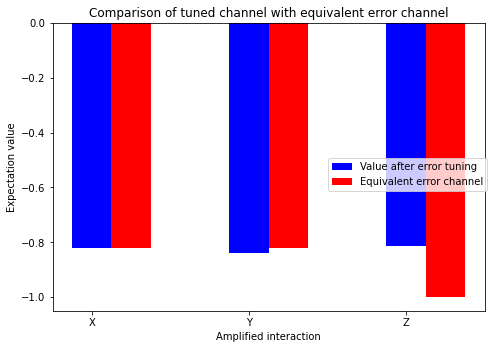

In [13]:
data = [[mitigated_value_x, mitigated_value_y, mitigated_value_z],
[unmitigated_value_x, unmitigated_value_y, unmitigated_value_z]]
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xticks(X, ('X', 'Y', 'Z'))
mitigated_bar = ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
unmitigated_bar = ax.bar(X + 0.25, data[1], color = 'r', width = 0.25)
fig.legend([mitigated_bar, unmitigated_bar], ["Value after error tuning", "Equivalent error channel"], loc="center right")
plt.xlabel("Amplified interaction")
plt.ylabel("Expectation value")
plt.title("Comparison of tuned channel with equivalent error channel")

## Analysis

Even though I was not able to get the canonical noise scaling to work, there are still some comparisons to be made between this and the parameter scaling. Firstly, I found that the respective overheads,
$$
\gamma_{ps} = \gamma^{1-\lambda} \ \ \ \ \ \ \ \gamma_{cns} = \gamma-\lambda(\gamma-1)
$$
are approximately equal if $\gamma \approx 1$, so there is little overhead advantage to one over the other. One challenge I encountered in the canonical scaling method was separating the distribution into positive and negative volumes. The sampling method given in the text takes advantage of the product form of the channel for efficient sampling, and I could not figure out how to leverage this for canonical scaling. My best guess was to convert the channel to a Pauli channel and then sample from that, but that distribution scales as $4^n$, so it would not be efficient. The parameter scaling method supports efficient sampling.

In the noise tuning method, I realized that the $Z$ errors did not affect the expectation value I was measuring. At high noise levels, omitting this parameter can benefit the overhead. I was happy to see the high agreement with the predicted values. I remember being skeptical when reading the NEPEC paper that noise could be tuned on individual gates, but this method would provide a way to scale up or down each interaction in the model on every gate or layer.